In [59]:
import numpy as np
import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, warnings
from mpl_toolkits.basemap import Basemap
plt.style.use('seaborn-whitegrid')
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
file_list = check_output(["ls", "../input"]).decode("utf8")
file_list = file_list.strip().split('\n')

air_reserve.csv
air_store_info.csv
air_visit_data.csv
date_info.csv
hpg_reserve.csv
hpg_store_info.csv
sample_submission.csv
store_id_relation.csv



# Read data and display info

In [4]:
for index, file in enumerate(file_list):
    var_name = file.rstrip('.csv')
    locals()[var_name] = pd.read_csv('../input/' + file)
    print(file)
    
    # convert to datetime
    for col in locals()[var_name].columns:
        if col.endswith('datetime') or col.endswith('date'):
            locals()[var_name][col] = pd.to_datetime(locals()[var_name][col])
    
    print('Shape:', locals()[var_name].shape)
    print('\n')
    print(locals()[var_name].info())
    print('\n')
    print(locals()[var_name].head())
    print('***********************************************************************************')

air_reserve.csv
Shape: (92378, 4)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92378 entries, 0 to 92377
Data columns (total 4 columns):
air_store_id        92378 non-null object
visit_datetime      92378 non-null datetime64[ns]
reserve_datetime    92378 non-null datetime64[ns]
reserve_visitors    92378 non-null int64
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 2.8+ MB
None


           air_store_id      visit_datetime    reserve_datetime  \
0  air_877f79706adbfb06 2016-01-01 19:00:00 2016-01-01 16:00:00   
1  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
2  air_db4b38ebe7a7ceff 2016-01-01 19:00:00 2016-01-01 19:00:00   
3  air_877f79706adbfb06 2016-01-01 20:00:00 2016-01-01 16:00:00   
4  air_db80363d35f10926 2016-01-01 20:00:00 2016-01-01 01:00:00   

   reserve_visitors  
0                 1  
1                 3  
2                 6  
3                 2  
4                 5  
**************************************************************

In [8]:
hpg_store_info.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


# Store Distribution map

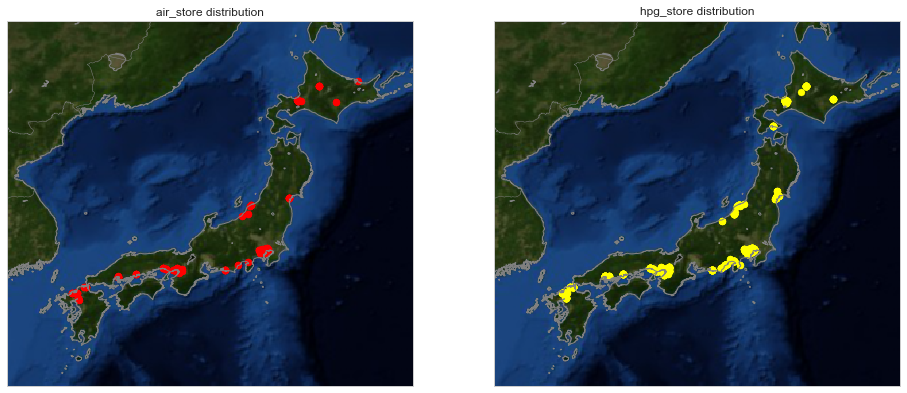

In [6]:
fig,ax = plt.subplots(1,2,figsize = (16,16))

color = ['red','yellow']
title = ['air_store distribution', 'hpg_store distribution']
for i,data in enumerate([air_store_info,hpg_store_info]):
    m = Basemap(resolution = 'h',lon_0 = 0, lat_0 = 0,llcrnrlon=127, urcrnrlon=147,
                      llcrnrlat=29, urcrnrlat=47, ax = ax[i])
    m.bluemarble()
    m.drawcoastlines(color = 'gray')
    m.drawcountries(color = 'gray')
    m.drawstates(color = 'gray')
    m.scatter(data['longitude'], data['latitude'], latlon = True, color = color[i], marker='o')
    ax[i].set_title(title[i])
    

# Visitors visualization

Aggregated vistors by visit date

Text(0.5,0,'visit date')

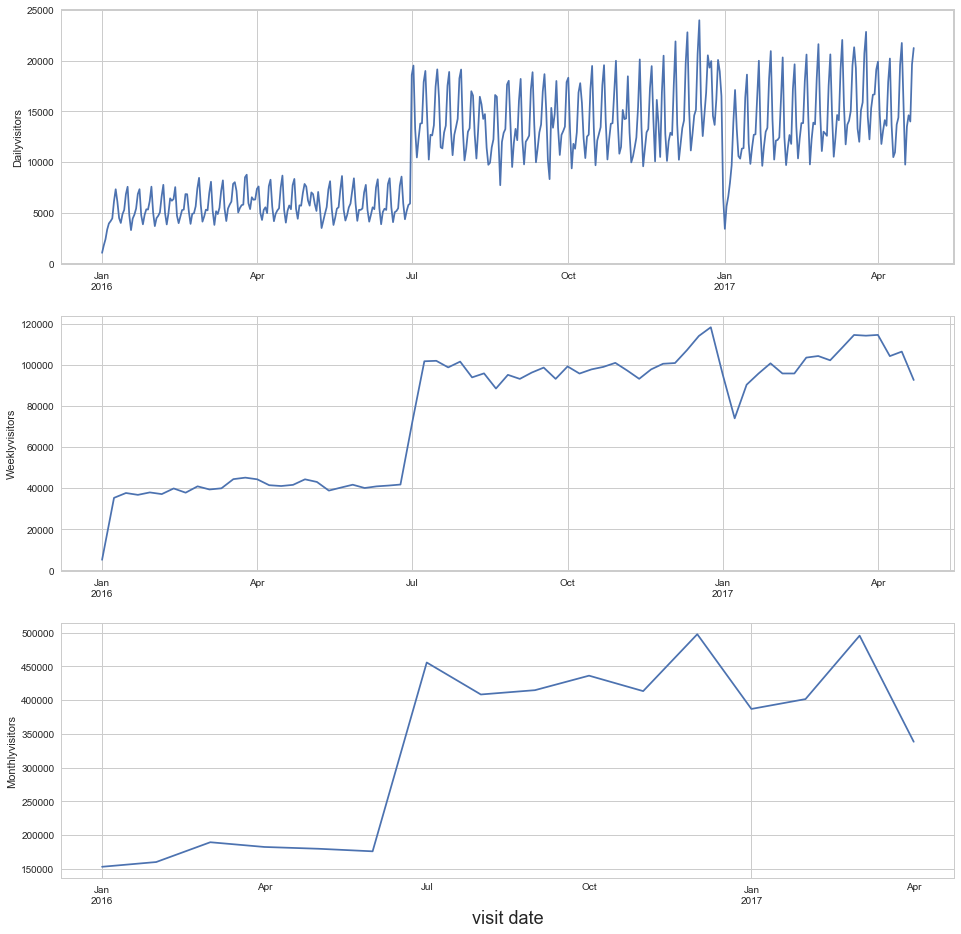

In [11]:
fig,ax = plt.subplots(3,1, figsize = (16,16))
Fre = ["Daily", "Weekly", "Monthly"]

for i,fre in enumerate(["D","W","M"]):
    air_visit_data.groupby('visit_date')['visitors'].sum().resample(fre).sum().plot(ax = ax[i])
    ax[i].set(ylabel = (Fre[i] + 'visitors'), xlabel = "")
plt.xlabel('visit date', fontsize = 18)

Let's get deeper into Reservasion dataset.

In [12]:
# convert hpg_store_id to air_store_id
hpg_reserve = hpg_reserve.merge(store_id_relation, on = 'hpg_store_id', how = 'left')
air = hpg_reserve['air_store_id']
hpg_reserve['hpg_store_id'] = air
hpg_reserve = hpg_reserve[hpg_reserve['hpg_store_id'].notnull()]
hpg_reserve = hpg_reserve.drop('air_store_id', axis = 1)
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
103,air_db80363d35f10926,2016-01-01 19:00:00,2016-01-01 15:00:00,4
121,air_08cb3c4ee6cd6a22,2016-01-01 19:00:00,2016-01-01 16:00:00,2
272,air_6b15edd1b4fbb96a,2016-01-02 17:00:00,2016-01-01 22:00:00,3
348,air_37189c92b6c761ec,2016-01-02 18:00:00,2016-01-02 17:00:00,2
349,air_37189c92b6c761ec,2016-01-02 18:00:00,2016-01-01 20:00:00,2


In [13]:
# add new feature, combine two dataset
def delta_reservation(df):
    df['delta_reservation'] = df['visit_datetime'] - df['reserve_datetime']
    df['delta_2days'] = df['delta_reservation'].apply(lambda x: int(x.days < 2))
    df['delta_7days'] = df['delta_reservation'].apply(lambda x: int(2 <= x.days < 7))
    df['delta_long'] = df['delta_reservation'].apply(lambda x: int(x.days >= 7))
    return df

air_reserve = delta_reservation(air_reserve)
hpg_reserve = delta_reservation(hpg_reserve)

air_reserve.rename(columns = {'air_store_id':'store_id'}, inplace = True)
hpg_reserve.rename(columns = {'hpg_store_id':'store_id'}, inplace = True)
total_reserve = pd.concat([air_reserve, hpg_reserve])
total_reserve['date'] = total_reserve['visit_datetime'].apply(lambda x:x.date())
total_reserve.head()

,store_id,visit_datetime,reserve_datetime,reserve_visitors,delta_reservation,delta_2days,delta_7days,delta_long,date
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,03:00:00,1,0,0,2016-01-01
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3,00:00:00,1,0,0,2016-01-01
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6,00:00:00,1,0,0,2016-01-01
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,04:00:00,1,0,0,2016-01-01
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5,19:00:00,1,0,0,2016-01-01


How many unique stores are reserved? How many unique stores are visited?

In [14]:
num_reserve = total_reserve['store_id'].nunique()
num_visit = air_visit_data['air_store_id'].nunique()
print("{} stores are reserved".format(num_reserve))
print("{} stores are visited".format(num_visit))

333 stores are reserved
829 stores are visited


Text(0.5,0,'Date')

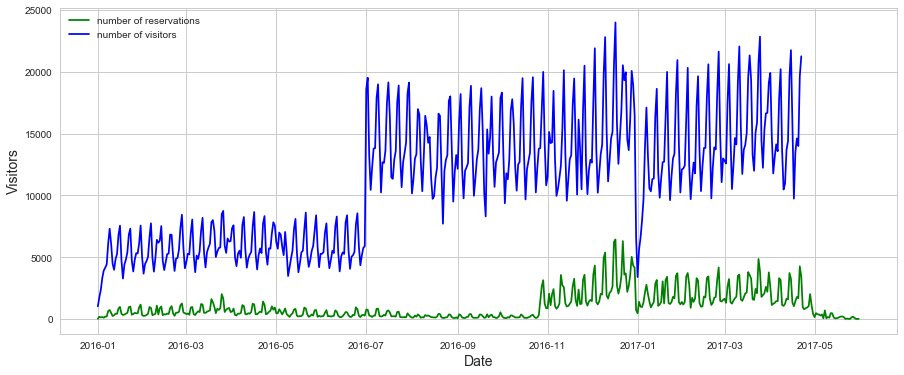

In [15]:
reserve_by_date = total_reserve.groupby('date').sum().reset_index()
visit_by_date = air_visit_data.groupby('visit_date').sum().reset_index()

plt.plot(reserve_by_date['date'], reserve_by_date['reserve_visitors'], color = 'green', label = 'number of reservations')
plt.plot(visit_by_date['visit_date'], visit_by_date['visitors'], color = 'blue', label = 'number of visitors')
plt.legend(loc = 'upper left')
plt.ylabel('Visitors', fontsize = 14)
plt.xlabel('Date', fontsize = 14)

What time do people usually make a reservation and visit?

(0, 86400)

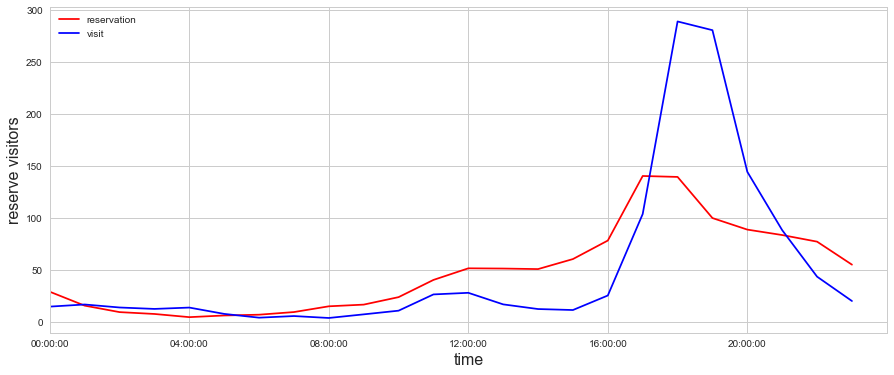

In [16]:
df1 = total_reserve.groupby('reserve_datetime')['reserve_visitors'].sum()
reserve_time = df1.groupby(df1.index.time).mean().reset_index()

df2 = total_reserve.groupby('visit_datetime')['reserve_visitors'].sum()
visit_time = df2.groupby(df2.index.time).mean().reset_index()

hourly_ticks = 4 * 60 * 60 * np.arange(6)
plt.plot(reserve_time['index'], reserve_time['reserve_visitors'],color = 'red', label = 'reservation')
plt.plot(visit_time['index'], visit_time['reserve_visitors'], color = 'blue', label = 'visit')
plt.xticks(hourly_ticks)
plt.legend(loc = 'upper left')
plt.ylabel('reserve visitors', fontsize = 16)
plt.xlabel('time', fontsize = 16)
plt.xlim(0,4 * 60 * 60 * 6)

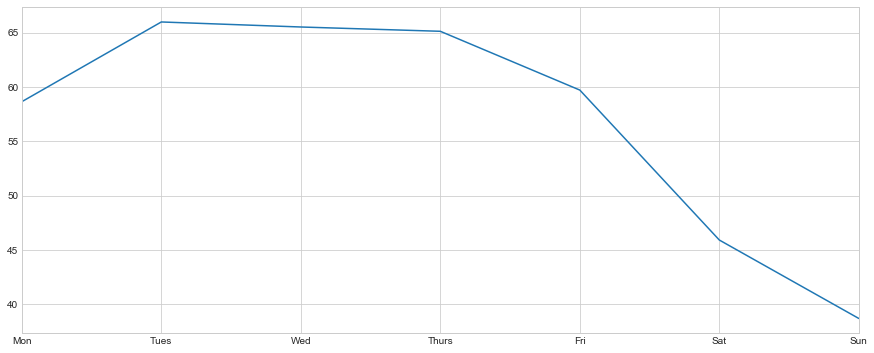

In [12]:
vy_weekday = df1.groupby(df1.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot();

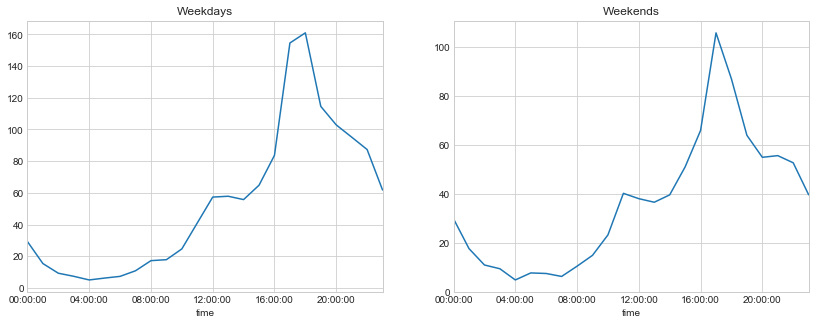

In [13]:
weekend = np.where(df1.index.weekday < 5, 'Weekday', 'Weekend')
by_time = df1.groupby([weekend, df1.index.time]).mean()

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.ix['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks)
by_time.ix['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks);

What are the distribution of time period between reserve and visit?

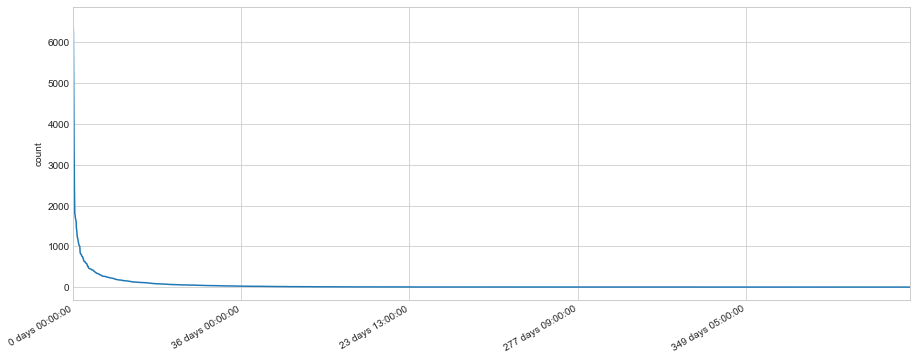

In [20]:
total_reserve['delta_reservation'].value_counts().plot()
plt.ylabel('count')

How many visitors for each time period?

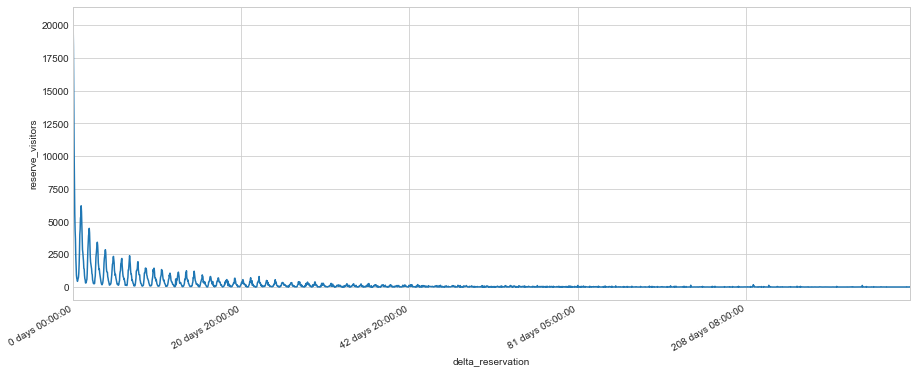

In [22]:
total_reserve.groupby('delta_reservation')['reserve_visitors'].sum().plot()
plt.ylabel('reserve_visitors')

What are the distribution of air_genre_name and air_area_name?

What is the holiday influence?

In [107]:
date_info = date_info.rename(columns = {'calendar_date':'visit_date'})
air_holiday = air_visit_data.merge(date_info, how = 'inner', on = 'visit_date')
air_holiday.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_25e9888d30b386df,2016-01-13,21,Wednesday,0
2,air_fd6aac1043520e83,2016-01-13,40,Wednesday,0
3,air_64d4491ad8cdb1c6,2016-01-13,5,Wednesday,0
4,air_ee3a01f0c71a769f,2016-01-13,18,Wednesday,0


In [26]:
air_holiday.groupby('holiday_flg')['visitors'].mean()

holiday_flg
0    20.828064
1    23.703327
Name: visitors, dtype: float64

Seems holiday has even a positive influence.

Which restaurants are similar? Cluster
K-means
plotly

Cluster EDA  ---> decide number of clusters
scatter plot
PCA/Cluster
PCA more deeply

counts per hour per restaurant

median income 
median price for the home
population
demographoic
how does sensonality affact data?
how many restaurant in the city?
Urban/Rural Area Classification

# Model Data Prepare

In [84]:
visit_by_store = train.groupby(["air_store_id"])["visitors"].aggregate([min,max,np.median,np.mean]).reset_index()
visit_by_store.head(3)

reserve_by_date = total_reserve.groupby(["store_id","date"]).sum().reset_index()
reserve_by_date = reserve_by_date.rename(columns = {'store_id':'air_store_id','date':'visit_date'})
reserve_by_date["visit_date"] = pd.to_datetime(reserve_by_date["visit_date"])
reserve_by_date.head(3)

,air_store_id,min,max,median,mean
0,air_00a91d42b08b08d9,1,99,26.0,26.081897
1,air_0164b9927d20bcc3,1,27,8.0,9.248322
2,air_0241aa3964b7f861,1,48,9.0,9.896465


,air_store_id,visit_date,reserve_visitors,delta_2days,delta_7days,delta_long
0,air_00a91d42b08b08d9,2016-01-14,2,0,1,0
1,air_00a91d42b08b08d9,2016-01-15,4,0,1,0
2,air_00a91d42b08b08d9,2016-01-16,2,0,1,0


In [111]:
train = air_visit_data.copy()
train = train.merge(reserve_by_date, how = "left", on=["air_store_id","visit_date"])
train = train.merge(visit_by_store,how = "left", on = "air_store_id")
train = train.merge(date_info, how = 'left', on = 'visit_date')
train["day_of_week"] = train["visit_date"].dt.weekday
train.head()
sum(train["reserve_visitors"].notnull())
sum(train["reserve_visitors"].isnull())

,air_store_id,visit_date,visitors,reserve_visitors,delta_2days,delta_7days,delta_long,min,max,median,mean,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,NaN,NaN,NaN,NaN,1,61,22.0,22.782609,2,0
1,air_ba937bf13d40fb24,2016-01-14,32,NaN,NaN,NaN,NaN,1,61,22.0,22.782609,3,0
2,air_ba937bf13d40fb24,2016-01-15,29,NaN,NaN,NaN,NaN,1,61,22.0,22.782609,4,0
3,air_ba937bf13d40fb24,2016-01-16,22,NaN,NaN,NaN,NaN,1,61,22.0,22.782609,5,0
4,air_ba937bf13d40fb24,2016-01-18,6,NaN,NaN,NaN,NaN,1,61,22.0,22.782609,0,0


35698

216410

In [68]:
from datetime import datetime, timedelta
train["lag_7"] = train["visit_date"] -  timedelta(days=7)

In [131]:
test = sample_submission.copy()
test["air_store_id"] = test["id"].apply(lambda x: x[0:20])
test["visit_date"] = test["id"].apply(lambda x: x[21:])
test["visit_date"] = pd.to_datetime(test["visit_date"])
test = test.merge(reserve_by_date, how = "left", on=["air_store_id","visit_date"])
test = test.merge(visit_by_store,how = "left", on = "air_store_id")
test = test.merge(date_info, how = 'left', on = 'visit_date')
test["day_of_week"] = test["visit_date"].dt.weekday
test.head()
sum(test["reserve_visitors"].notnull())
sum(test["reserve_visitors"].isnull())

,id,visitors,air_store_id,visit_date,reserve_visitors,delta_2days,delta_7days,delta_long,min,max,median,mean,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23,NaN,NaN,NaN,NaN,1,99,26.0,26.081897,6,0
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24,NaN,NaN,NaN,NaN,1,99,26.0,26.081897,0,0
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25,NaN,NaN,NaN,NaN,1,99,26.0,26.081897,1,0
3,air_00a91d42b08b08d9_2017-04-26,0,air_00a91d42b08b08d9,2017-04-26,NaN,NaN,NaN,NaN,1,99,26.0,26.081897,2,0
4,air_00a91d42b08b08d9_2017-04-27,0,air_00a91d42b08b08d9,2017-04-27,NaN,NaN,NaN,NaN,1,99,26.0,26.081897,3,0


1269

30750

# Linear Regression

In [132]:
import statsmodels.api as sm

In [133]:
train_x = train.drop(["visitors","air_store_id","visit_date","delta_7days"],axis=1)
train_x = train_x.fillna(0)
train_y = train["visitors"]

test_x = test.drop(["id","visitors","air_store_id","visit_date","delta_7days"],axis=1)
test_x = test_x.fillna(0)
test_y = test["visitors"]

In [134]:
x = sm.add_constant(train_x, has_constant='add')

In [135]:
est = sm.OLS(train_y, x)
est = est.fit()
print(est.summary()) 

                            OLS Regression Results                            
Dep. Variable:               visitors   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                 2.448e+04
Date:                Fri, 26 Jan 2018   Prob (F-statistic):               0.00
Time:                        01:08:18   Log-Likelihood:            -9.8920e+05
No. Observations:              252108   AIC:                         1.978e+06
Df Residuals:                  252098   BIC:                         1.979e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.6093      0.068  

In [136]:
pred_x = sm.add_constant(test_x, has_constant='add')
pred_y= est.predict(pred_x)

In [141]:
sample_submission["visitors"] = pred_y
sample_submission["visitors"] = sample_submission["visitors"].apply(lambda x: 0 if x<0 else x)
sample_submission.head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,29.884692
1,air_00a91d42b08b08d9_2017-04-24,20.791080
2,air_00a91d42b08b08d9_2017-04-25,22.306682
3,air_00a91d42b08b08d9_2017-04-26,23.822284
4,air_00a91d42b08b08d9_2017-04-27,25.337886


In [143]:
sample_submission.to_csv("../output/lm1.csv",index=False)